In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

### 1. Results before and after noise injection

In [2]:
# 1) Load all CSVs into one DataFrame
files = glob.glob("window3/*[1-5].csv")
dfs   = [pd.read_csv(f) for f in files]
df    = pd.concat(dfs, ignore_index=True)

In [3]:
# 1) Aggregate means and SEMs per language-tense
agg = (
    df
    .groupby(['language','tense'])
    .agg(
        p_clean_mean  = ('p_clean', 'mean'),
        p_clean_sem   = ('p_clean', lambda x: x.std(ddof=1)/np.sqrt(len(x))),
        p_corrupt_mean= ('p_corrupt', 'mean'),
        p_corrupt_sem = ('p_corrupt', lambda x: x.std(ddof=1)/np.sqrt(len(x)))
    )
    .reset_index()
)

In [7]:
# 2) Melt to long format for seaborn
plot_df = agg.melt(
    id_vars=['language','tense'],
    value_vars=['p_clean_mean','p_corrupt_mean'],
    var_name='condition',
    value_name='mean_prob'
)
# Map sem values as well
sem_map = {
    'p_clean_mean': 'p_clean_sem',
    'p_corrupt_mean': 'p_corrupt_sem'
}
plot_df['psem'] = plot_df['condition'].map(sem_map)
plot_df['psem'] = plot_df.apply(lambda row: agg.loc[
    (agg.language==row.language)&(agg.tense==row.tense),
    row['psem']
].values[0], axis=1)

cat_type = pd.CategoricalDtype(categories=lang_order, ordered=True)
plot_df['language'] = plot_df['language'].astype(cat_type)

In [6]:
lang_order = ["en","de","fr","it","pt","es","hi","th"]

#### 1.1 Bar plot

In [8]:
agg_df = (
    plot_df
    .groupby(['language', 'condition'])
    .agg(
        mean_prob=('mean_prob', 'mean'),
        psem=('mean_prob', 'sem')
    )
    .reset_index()
)

/var/tmp/pbs.11563285.pbs-m1.metacentrum.cz/ipykernel_922096/4005127505.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['language', 'condition'])


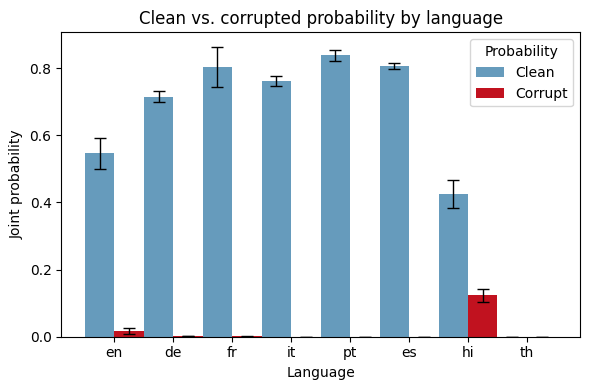

In [9]:
pivot_mean = agg_df.pivot(index='language', columns='condition', values='mean_prob')
pivot_sem  = agg_df.pivot(index='language', columns='condition', values='psem')

# 3) Define order, offsets, colors
lang_order = ["en","de","fr","it","pt","es","hi","th"]
conditions = ['p_clean_mean', 'p_corrupt_mean']
palette    = ['#669bbc', '#c1121f']
width      = 0.5
x          = np.arange(len(lang_order))

# 4) Plot
plt.figure(figsize=(6, 4))
for i, cond in enumerate(conditions):
    means = pivot_mean.loc[lang_order, cond]
    sems  = pivot_sem.loc[lang_order, cond]
    plt.bar(
        x + (i - 0.5) * width,
        means,
        width,
        yerr=sems,
        capsize=4,
        error_kw={'elinewidth': 1},
        color=palette[i]
    )

# 5) Finalize
plt.xticks(x, lang_order)
plt.xlabel('Language')
plt.ylabel(r'Joint probability')
plt.title('Clean vs. corrupted probability by language')
plt.legend(['Clean', 'Corrupt'], title='Probability')
plt.tight_layout()
plt.show()

### 2. Why do we need context in our prompt? (Zero-shot vs. One-shot)

In [10]:
files = glob.glob("window3/*_en[1-5].csv")
dfs   = [pd.read_csv(f) for f in files]
df_orig    = pd.concat(dfs, ignore_index=True)

In [11]:
files = glob.glob("window3_zeroshot/*[1-5].csv")
dfs   = [pd.read_csv(f) for f in files]
df_zero    = pd.concat(dfs, ignore_index=True)

In [12]:
# 2) Aggregate means + SEMs by tense and condition
def summarize(df, label):
    agg = (
      df
      .groupby('tense')['delta_restored']
      .agg(mean='mean', sem=lambda x: x.std(ddof=1)/np.sqrt(len(x)))
      .reset_index()
    )
    agg['condition'] = label
    return agg

agg_ctx = summarize(df_orig, 'one-shot')
agg_zero = summarize(df_zero, 'zero‐shot')
plot_df = pd.concat([agg_ctx, agg_zero], ignore_index=True)

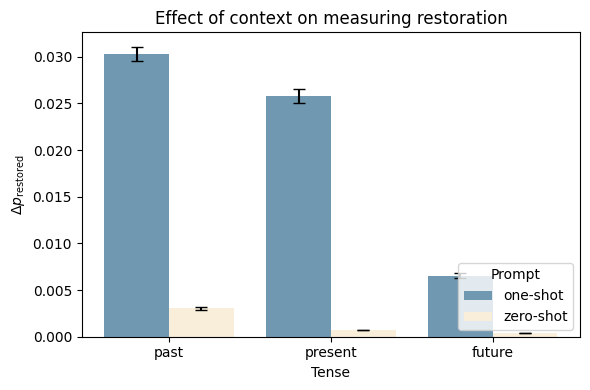

In [13]:
# 3) Draw grouped bar chart
tense_order = ['pas', 'pre', 'fut']
tense_order_label = ['past', 'present', 'future']

plt.figure(figsize=(6,4))
sns.barplot(
    data=plot_df,
    x='tense', y='mean',
    hue='condition',
    palette=['#669bbc','#fdf0d5'],
    errorbar=None,
    order=tense_order
)
# Add error bars
for i, row in plot_df.iterrows():
    x = tense_order.index(row['tense'])
    offset = -0.2 if row.condition=='one-shot' else 0.2
    plt.errorbar(
        x + offset,
        row['mean'],
        yerr=row['sem'],
        color='k',
        capsize=4,
        fmt='none'
    )

plt.xticks(ticks=range(len(tense_order)), labels=tense_order_label)
plt.legend(title='Prompt', loc='lower right')
plt.ylabel(r'$\Delta p_{\mathrm{restored}}$')
plt.xlabel('Tense')
plt.title('Effect of context on measuring restoration')
plt.tight_layout()
plt.show()

### 3. Nonce test

In [20]:
# 1) Load all CSVs into one DataFrame
files = glob.glob("window3_nonce/*.csv")
dfs   = [pd.read_csv(f) for f in files]
df_nonce    = pd.concat(dfs, ignore_index=True)

setup = {
    "en": "nonce"
}

df_nonce["setup"] = df_nonce["language"].map(setup)

In [21]:
files = glob.glob("window3_tonce/*.csv")
dfs   = [pd.read_csv(f) for f in files]
df_tonce    = pd.concat(dfs, ignore_index=True)

setup = {
    "en": "nonce_w_temporal"
}

df_tonce["setup"] = df_tonce["language"].map(setup)

In [22]:
files = glob.glob("window3/*_en[1-5].csv")
dfs   = [pd.read_csv(f) for f in files]
df_orig    = pd.concat(dfs, ignore_index=True)

setup = {
    "en": "original"
}

df_orig["setup"] = df_orig["language"].map(setup)

In [23]:
df = pd.concat([df_orig, df_nonce, df_tonce], ignore_index=True)
# df = pd.concat([df_nonce, df_tonce], ignore_index=True)

In [79]:
list(df)

['language',
 'tense',
 'stream',
 'prompt_id',
 'pos',
 'noise_seed',
 'restore_layer',
 'gold',
 'p_clean',
 'p_corrupt',
 'p_restored',
 'delta_corrupt',
 'delta_restored',
 'setup']

#### Peak layer

In [58]:
# Step 1: For each (setup, stream, restore_layer, tense, noise_seed, prompt_id),
# record the maximum delta_restored
group = (
    df
    .groupby(["setup","stream","restore_layer","tense","noise_seed","prompt_id"])
    ["delta_restored"]
    .max()
    .reset_index()
)

In [59]:
list(group)

['setup',
 'stream',
 'restore_layer',
 'tense',
 'noise_seed',
 'prompt_id',
 'delta_restored']

In [60]:
# Step 2: For each (setup, stream, tense, noise_seed, prompt_id),
# find the layer at which delta_restored is maximal, and keep its delta_restored
peaks = (
    group
    .groupby(["setup", "stream", "tense", "noise_seed", "prompt_id"])
    .apply(
        lambda subdf: subdf.loc[
            subdf["delta_restored"].idxmax(),
            ["restore_layer", "delta_restored"]
        ]
    )
    .reset_index()
    .rename(columns={"restore_layer": "peak_layer"})
)

/var/tmp/pbs.11172543.pbs-m1.metacentrum.cz/ipykernel_259663/673199230.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [61]:
def summarize_group(df_group):
    mode_layer = df_group["peak_layer"].mode()[0]
    mask = df_group["peak_layer"] == mode_layer
    mean_delta = df_group.loc[mask, "delta_restored"].mean()
    std_delta = df_group.loc[mask, "delta_restored"].std()
    return pd.Series({
        "peak_layer": mode_layer,
        "delta_restored": mean_delta,
        "std": std_delta
    })

summary = (
    peaks
    .groupby(["setup", "tense", "stream"])
    .apply(summarize_group)
    .reset_index()
)

/var/tmp/pbs.11172543.pbs-m1.metacentrum.cz/ipykernel_259663/764515456.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(summarize_group)


In [62]:
from IPython.display import display

def print_stream_table(df_summary, stream_name):
    df_stream = df_summary[df_summary["stream"] == stream_name][
        ["setup", "tense", "stream", "peak_layer", "std", "delta_restored"]
    ]
    df_stream["std"] = df_stream["std"].round(2)
    df_stream["delta_restored"] = df_stream["delta_restored"].round(4)
    display(df_stream)

In [63]:
# Example: print tables for each stream
for stream_name in summary["stream"].unique():
    print_stream_table(summary, stream_name)

,setup,tense,stream,peak_layer,std,delta_restored
0,nonce,fut,attention_output,16.0,0.20,0.5372
4,nonce,pas,attention_output,26.0,0.00,0.0000
8,nonce,pre,attention_output,26.0,0.00,0.0003
12,nonce_w_temporal,fut,attention_output,16.0,0.16,0.6149
16,nonce_w_temporal,pas,attention_output,26.0,0.00,0.0000
20,nonce_w_temporal,pre,attention_output,26.0,0.00,0.0000
24,original,fut,attention_output,16.0,0.16,0.5940
28,original,pas,attention_output,16.0,0.36,0.3687
32,original,pre,attention_output,16.0,0.32,0.3768


,setup,tense,stream,peak_layer,std,delta_restored
1,nonce,fut,block_output,30.0,0.01,0.9713
5,nonce,pas,block_output,29.0,0.00,0.0005
9,nonce,pre,block_output,14.0,0.00,0.0003
13,nonce_w_temporal,fut,block_output,30.0,0.01,0.9704
17,nonce_w_temporal,pas,block_output,25.0,0.00,0.0000
21,nonce_w_temporal,pre,block_output,2.0,0.00,0.0000
25,original,fut,block_output,30.0,0.02,0.9621
29,original,pas,block_output,3.0,0.00,0.5854
33,original,pre,block_output,30.0,0.06,0.8464


,setup,tense,stream,peak_layer,std,delta_restored
2,nonce,fut,mlp_activation,30.0,0.06,0.2030
6,nonce,pas,mlp_activation,15.0,0.00,0.0000
10,nonce,pre,mlp_activation,30.0,0.00,0.0001
14,nonce_w_temporal,fut,mlp_activation,30.0,0.04,0.2357
18,nonce_w_temporal,pas,mlp_activation,15.0,0.00,0.0000
22,nonce_w_temporal,pre,mlp_activation,15.0,0.00,0.0000
26,original,fut,mlp_activation,30.0,0.03,0.1488
30,original,pas,mlp_activation,14.0,0.18,0.2908
34,original,pre,mlp_activation,13.0,0.05,0.6172


,setup,tense,stream,peak_layer,std,delta_restored
3,nonce,fut,mlp_output,29.0,0.05,0.1081
7,nonce,pas,mlp_output,14.0,0.00,0.0000
11,nonce,pre,mlp_output,14.0,0.00,0.0000
15,nonce_w_temporal,fut,mlp_output,12.0,0.19,0.2444
19,nonce_w_temporal,pas,mlp_output,14.0,0.00,0.0000
23,nonce_w_temporal,pre,mlp_output,14.0,0.00,0.0000
27,original,fut,mlp_output,23.0,0.00,0.0725
31,original,pas,mlp_output,14.0,0.26,0.3120
35,original,pre,mlp_output,1.0,0.07,0.5828


### Nonce test original vs. corrupted probs

In [64]:
df = pd.concat([df_orig, df_nonce, df_tonce], ignore_index=True)

In [65]:
agg = (
    df
    .groupby(['setup','tense'])
    .agg(
        p_clean_mean  = ('p_clean', 'mean'),
        p_clean_sem   = ('p_clean', lambda x: x.std(ddof=1)/np.sqrt(len(x))),
        p_corrupt_mean= ('p_corrupt', 'mean'),
        p_corrupt_sem = ('p_corrupt', lambda x: x.std(ddof=1)/np.sqrt(len(x)))
    )
    .reset_index()
)

In [66]:
# 2) Melt to long format for seaborn
plot_df = agg.melt(
    id_vars=['setup','tense'],
    value_vars=['p_clean_mean','p_corrupt_mean'],
    var_name='condition',
    value_name='mean_prob'
)
# Map sem values as well
sem_map = {
    'p_clean_mean': 'p_clean_sem',
    'p_corrupt_mean': 'p_corrupt_sem'
}
plot_df['psem'] = plot_df['condition'].map(sem_map)
plot_df['psem'] = plot_df.apply(lambda row: agg.loc[
    (agg.setup==row.setup)&(agg.tense==row.tense),
    row['psem']
].values[0], axis=1)

lang_order = ["original", "nonce", "nonce_w_temporal"]
cat_type = pd.CategoricalDtype(categories=lang_order, ordered=True)
plot_df['setup'] = plot_df['setup'].astype(cat_type)

In [67]:
agg_df = (
    plot_df
    .groupby(['setup', 'condition'])
    .agg(
        mean_prob=('mean_prob', 'mean'),
        psem=('mean_prob', 'sem')
    )
    .reset_index()
)

/var/tmp/pbs.11172543.pbs-m1.metacentrum.cz/ipykernel_259663/2715551734.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['setup', 'condition'])


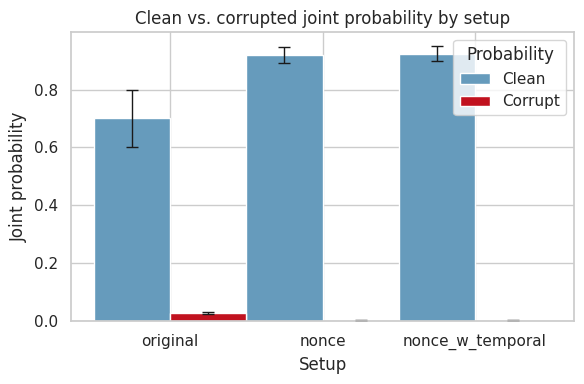

In [68]:
pivot_mean = agg_df.pivot(index='setup', columns='condition', values='mean_prob')
pivot_sem  = agg_df.pivot(index='setup', columns='condition', values='psem')

# 3) Define order, offsets, colors
conditions = ['p_clean_mean', 'p_corrupt_mean']
palette    = ['#669bbc', '#c1121f']
width      = 0.5
x          = np.arange(len(lang_order))

# 4) Plot
plt.figure(figsize=(6, 4))
for i, cond in enumerate(conditions):
    means = pivot_mean.loc[lang_order, cond]
    sems  = pivot_sem.loc[lang_order, cond]
    plt.bar(
        x + (i - 0.5) * width,
        means,
        width,
        yerr=sems,
        capsize=4,
        error_kw={'elinewidth': 1},
        color=palette[i]
    )

# 5) Finalize
plt.xticks(x, lang_order)
plt.xlabel('Setup')
plt.ylabel(r'Joint probability')
plt.title('Clean vs. corrupted joint probability by setup')
plt.legend(['Clean', 'Corrupt'], title='Probability')
plt.tight_layout()
plt.show()

### Spearman's rho correlation analysis

In [69]:
df = pd.concat([df_orig, df_nonce, df_tonce], ignore_index=True)

In [70]:
# (a) First collapse over prompt_id, so we average δp per (language,stream,layer,tense,seed)
group = (
    df
    .groupby(["setup","stream","restore_layer","tense","noise_seed","prompt_id"])
    ["delta_restored"]
    .max()
    .reset_index()
)

# (b) Compute mean and SEM of δp over noise_seed for each (language,stream,layer,tense)
agg = (
    group
    .groupby(["setup","stream","restore_layer","tense"])["delta_restored"]
    .agg(
        mean   = "mean",
        sem    = lambda x: x.std(ddof=1) / np.sqrt(len(x))
    )
    .reset_index()
)

In [71]:
# 2) Normalize each (setup,stream,tense) curve by its max
agg['norm_delta'] = (
    agg
    .groupby(['setup','stream','tense'])['mean']
    .transform(lambda x: x / x.max())
)

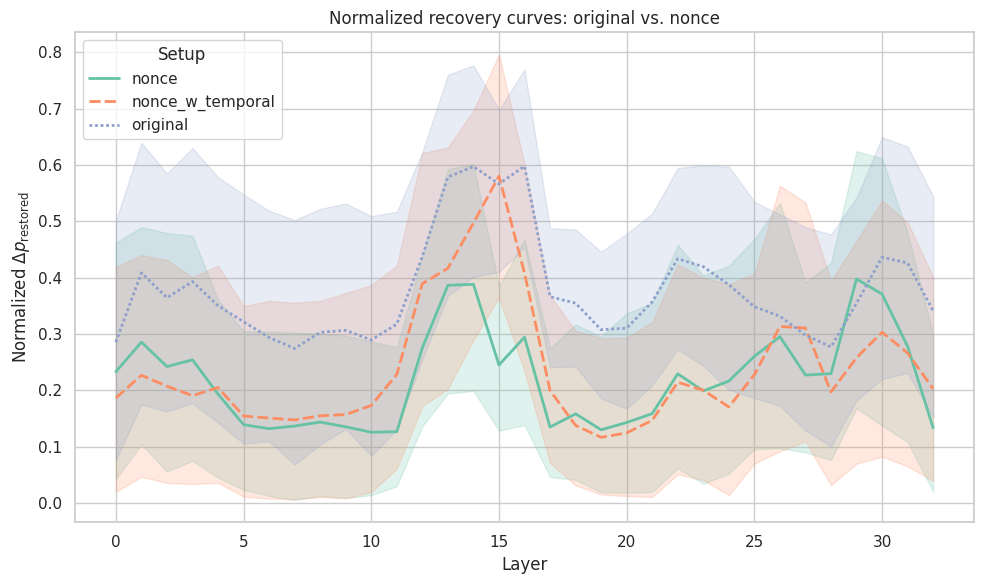

In [72]:
# 3) Plot normalized curves
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.lineplot(
    data=agg,
    x='restore_layer',
    y='norm_delta',
    hue='setup',
    style='setup',
    palette='Set2',
    linewidth=2.0
)
plt.xlabel('Layer')
plt.ylabel(r'Normalized $\Delta p_{\mathrm{restored}}$')
plt.title('Normalized recovery curves: original vs. nonce')
plt.legend(title='Setup', loc='best')
plt.tight_layout()
plt.show()

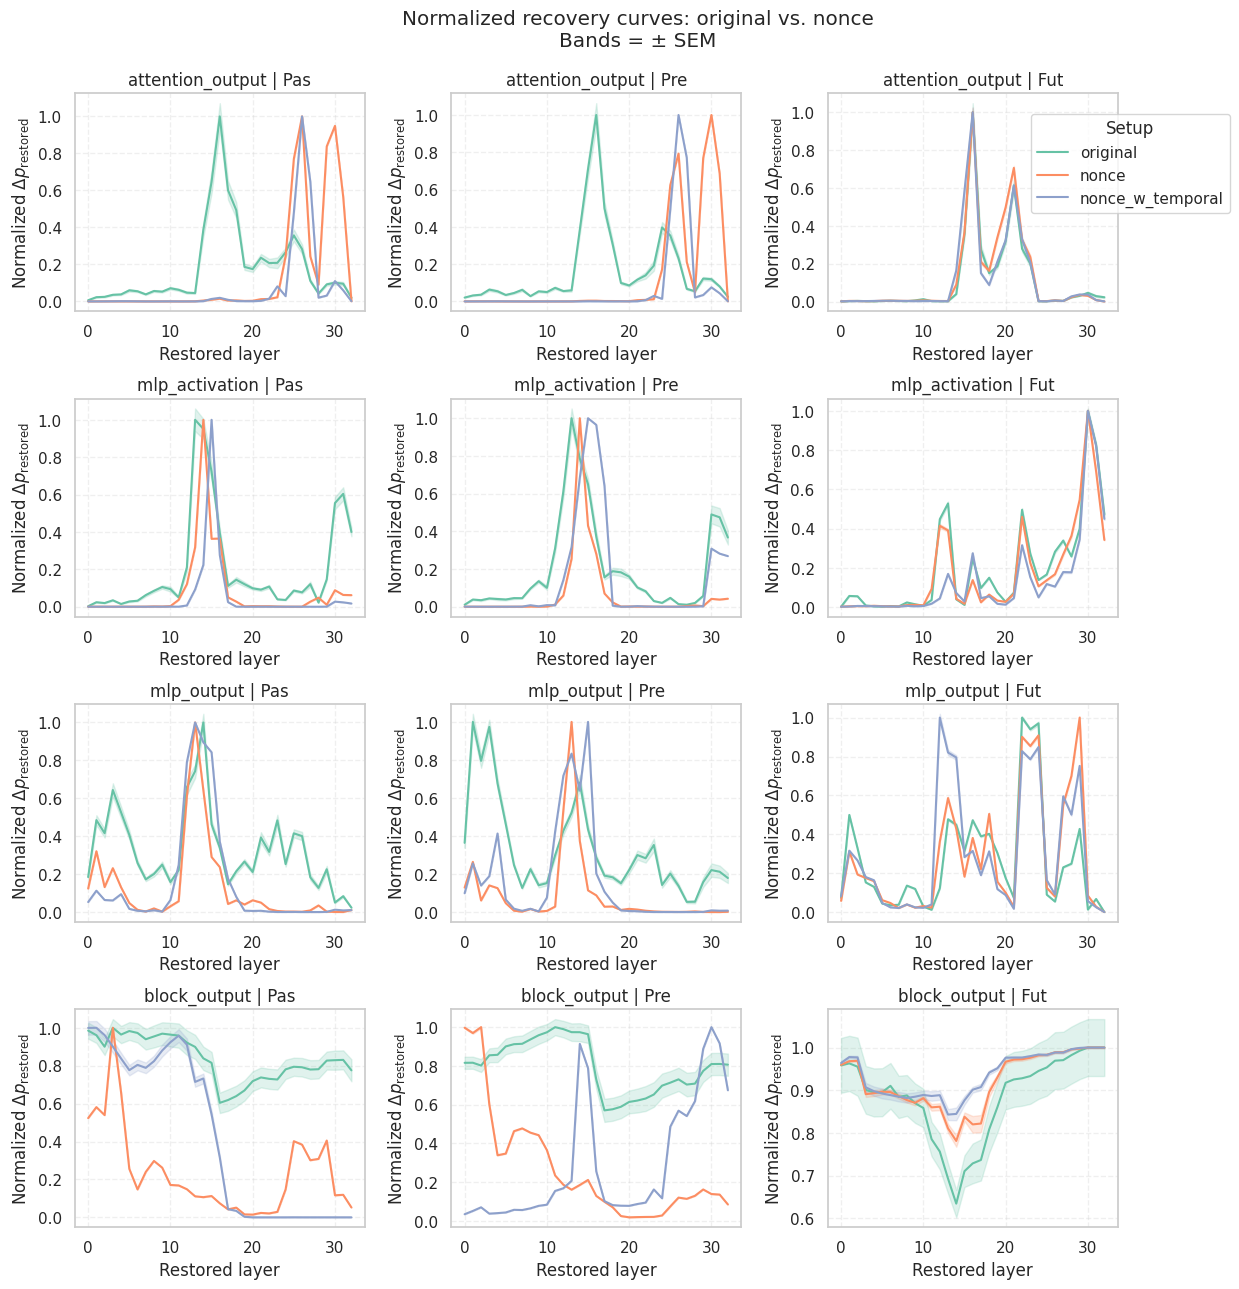

In [73]:
setup_order = ["original", "nonce", "nonce_w_temporal"]
# setup_order = ["nonce", "nonce_w_temporal"]

palette   = dict(zip(setup_order, sns.color_palette("Set2", n_colors=len(setup_order))))

streams = ["attention_output", "mlp_activation", "mlp_output", "block_output"]        # e.g. ["attention_output", "mlp_activation", ...]
tenses  = ["pas", "pre", "fut"]
# ylim = [0.6, 0.5, 0.5, 1.0]

n_rows = len(streams)
n_cols = len(tenses)
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 3.5 * n_rows),
    sharey=False
)

# If there's only one row or column, make axes 2D for consistency
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)
if n_cols == 1:
    axes = np.expand_dims(axes, axis=1)

# ─── DRAW LINES AND BANDS INLINE ───────────────────────────────────────────────
for i, stream in enumerate(streams):
    for j, tense in enumerate(tenses):
        ax = axes[i][j]
        sub = agg[(agg["stream"] == stream) & (agg["tense"] == tense)]
        
        # Fplot mean ± SEM vs. restore_layer
        for lang in setup_order:
            sl = sub[sub["setup"] == lang].sort_values("restore_layer")
            if sl.empty:
                continue
            x = sl["restore_layer"]
            y = sl["norm_delta"]
            se = sl["sem"]
            
            ax.plot(
                x, y,
                label=lang,
                color=palette[lang]
            )
            ax.fill_between(
                x,
                y - se,
                y + se,
                alpha=0.2,
                color=palette[lang]
            )
            
#         ax.set_ylim(0.0, ylim[i])
        ax.set_title(f"{stream} | {tense.capitalize()}")
        ax.set_xlabel("Restored layer")
        ax.set_ylabel(r"Normalized $\Delta p_{\mathrm{restored}}$")
        ax.grid(True, linestyle='--', alpha=0.3)

# ─── ADD LEGEND ───────────────────────────────────────────────────────────────
# Place a single legend outside on the right
handles, labels = axes[0][1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Setup",
    bbox_to_anchor=(0.9, 0.87),
    loc="center right"
)

plt.subplots_adjust(
    top=0.92,
    right=0.82,
    hspace=0.4,
    wspace=0.3
)
fig.suptitle("Normalized recovery curves: original vs. nonce\nBands = ± SEM", y=0.98)
plt.show()

In [74]:
df = pd.concat([df_orig, df_nonce], ignore_index=True)

rho↑, p-value↓

null hypothesis check threshold for p-value -> 5% -> 0.05

In [76]:
def sig_stars(p):
    if p < 1e-3:
        return '***'
    elif p < 1e-2:
        return '**'
    elif p < 5e-2:
        return '*'
    else:
        return ''

print("Spearman rank correlations (original vs. nonce):")
for (stream, tense), group in agg.groupby(['stream','tense']):
    orig = group[group.setup=='original'].sort_values('restore_layer')['norm_delta'].values
    nonc = group[group.setup=='nonce'].sort_values('restore_layer')['norm_delta'].values
    rho, pval = spearmanr(orig, nonc)
    stars = sig_stars(pval)
    print(f"  {stream:16s} | {tense:3s} : ρ = {rho:.3f}, p = {pval:.3g} {stars}")

Spearman rank correlations (original vs. nonce):
  attention_output | fut : ρ = 0.902, p = 8.01e-13 ***
  attention_output | pas : ρ = 0.612, p = 0.000156 ***
  attention_output | pre : ρ = 0.663, p = 2.61e-05 ***
  block_output     | fut : ρ = 0.950, p = 3.35e-17 ***
  block_output     | pas : ρ = 0.686, p = 1.04e-05 ***
  block_output     | pre : ρ = 0.727, p = 1.66e-06 ***
  mlp_activation   | fut : ρ = 0.934, p = 2.19e-15 ***
  mlp_activation   | pas : ρ = 0.841, p = 9.32e-10 ***
  mlp_activation   | pre : ρ = 0.796, p = 3.03e-08 ***
  mlp_output       | fut : ρ = 0.862, p = 1.13e-10 ***
  mlp_output       | pas : ρ = 0.578, p = 0.000429 ***
  mlp_output       | pre : ρ = 0.776, p = 1.14e-07 ***


### Layer-level recovery (w=1)

In [2]:
# 1) Load all CSVs into one DataFrame
files = glob.glob("window1_nonce/nonce*.csv")
dfs   = [pd.read_csv(f) for f in files]
df_nonce    = pd.concat(dfs, ignore_index=True)

setup = {
    "en": "nonce"
}

df_nonce["setup"] = df_nonce["language"].map(setup)

In [9]:
# 1) Load all CSVs into one DataFrame
files = glob.glob("window1_nonce/tonce*.csv")
dfs   = [pd.read_csv(f) for f in files]
df_tonce    = pd.concat(dfs, ignore_index=True)

setup = {
    "en": "nonce_w_temporal"
}

df_tonce["setup"] = df_tonce["language"].map(setup)

In [5]:
files = glob.glob("window3/*_en[1-5].csv")
dfs   = [pd.read_csv(f) for f in files]
df_orig    = pd.concat(dfs, ignore_index=True)

setup = {
    "en": "original"
}

df_orig["setup"] = df_orig["language"].map(setup)

In [10]:
df = pd.concat([df_orig, df_nonce, df_tonce], ignore_index=True)

In [13]:
agg = (
    df
    .groupby(['setup','tense'])
    .agg(
        p_clean_mean  = ('p_clean', 'mean'),
        p_clean_sem   = ('p_clean', lambda x: x.std(ddof=1)/np.sqrt(len(x))),
        p_corrupt_mean= ('p_corrupt', 'mean'),
        p_corrupt_sem = ('p_corrupt', lambda x: x.std(ddof=1)/np.sqrt(len(x)))
    )
    .reset_index()
)

# 2) Melt to long format for seaborn
plot_df = agg.melt(
    id_vars=['setup','tense'],
    value_vars=['p_clean_mean','p_corrupt_mean'],
    var_name='condition',
    value_name='mean_prob'
)
# Map sem values as well
sem_map = {
    'p_clean_mean': 'p_clean_sem',
    'p_corrupt_mean': 'p_corrupt_sem'
}
plot_df['psem'] = plot_df['condition'].map(sem_map)
plot_df['psem'] = plot_df.apply(lambda row: agg.loc[
    (agg.setup==row.setup)&(agg.tense==row.tense),
    row['psem']
].values[0], axis=1)

lang_order = ["original", "nonce", "nonce_w_temporal"]
cat_type = pd.CategoricalDtype(categories=lang_order, ordered=True)
plot_df['setup'] = plot_df['setup'].astype(cat_type)

agg_df = (
    plot_df
    .groupby(['setup', 'condition'])
    .agg(
        mean_prob=('mean_prob', 'mean'),
        psem=('mean_prob', 'sem')
    )
    .reset_index()
)

/var/tmp/pbs.11189753.pbs-m1.metacentrum.cz/ipykernel_747408/4068022967.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['setup', 'condition'])


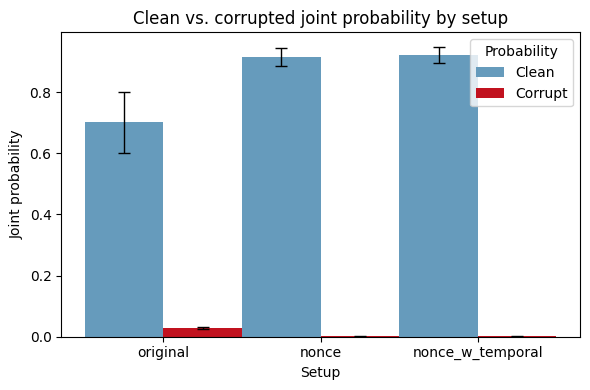

In [14]:
pivot_mean = agg_df.pivot(index='setup', columns='condition', values='mean_prob')
pivot_sem  = agg_df.pivot(index='setup', columns='condition', values='psem')

# 3) Define order, offsets, colors
conditions = ['p_clean_mean', 'p_corrupt_mean']
palette    = ['#669bbc', '#c1121f']
width      = 0.5
x          = np.arange(len(lang_order))

# 4) Plot
plt.figure(figsize=(6, 4))
for i, cond in enumerate(conditions):
    means = pivot_mean.loc[lang_order, cond]
    sems  = pivot_sem.loc[lang_order, cond]
    plt.bar(
        x + (i - 0.5) * width,
        means,
        width,
        yerr=sems,
        capsize=4,
        error_kw={'elinewidth': 1},
        color=palette[i]
    )

# 5) Finalize
plt.xticks(x, lang_order)
plt.xlabel('Setup')
plt.ylabel(r'Joint probability')
plt.title('Clean vs. corrupted joint probability by setup')
plt.legend(['Clean', 'Corrupt'], title='Probability')
plt.tight_layout()
plt.show()

In [15]:
# (a) First collapse over prompt_id, so we average δp per (language,stream,layer,tense,seed)
group = (
    df
    .groupby(["setup","stream","restore_layer","tense","noise_seed","prompt_id"])
    ["delta_restored"]
    .max()
    .reset_index()
)

# (b) Compute mean and SEM of δp over noise_seed for each (language,stream,layer,tense)
agg = (
    group
    .groupby(["setup","stream","restore_layer","tense"])["delta_restored"]
    .agg(
        mean   = "mean",
        sem    = lambda x: x.std(ddof=1) / np.sqrt(len(x))
    )
    .reset_index()
)

In [16]:
# 2) Normalize each (setup,stream,tense) curve by its max
agg['norm_delta'] = (
    agg
    .groupby(['setup','stream','tense'])['mean']
    .transform(lambda x: x / x.max())
)

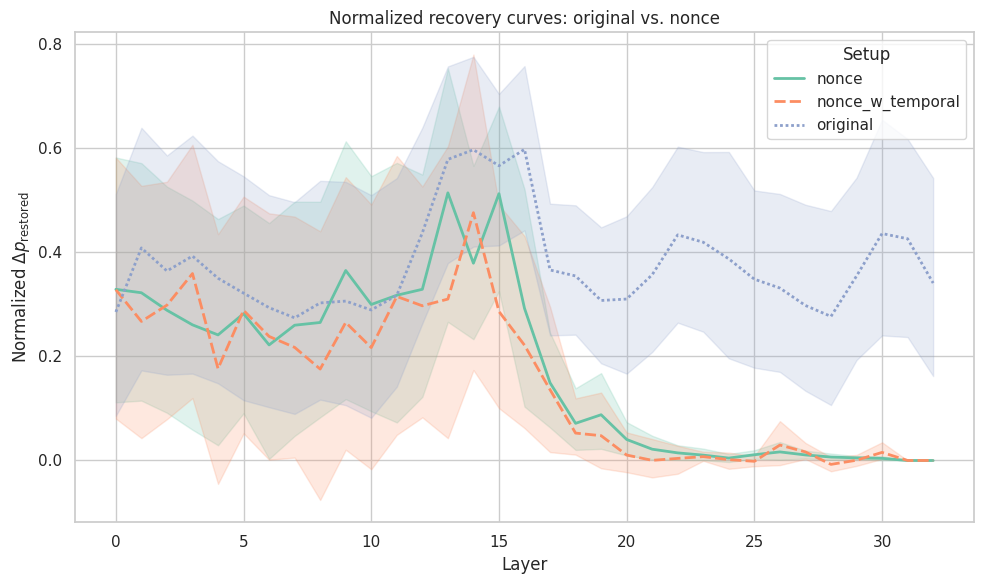

In [17]:
# 3) Plot normalized curves
sns.set(style="whitegrid")
plt.figure(figsize=(10,6))
sns.lineplot(
    data=agg,
    x='restore_layer',
    y='norm_delta',
    hue='setup',
    style='setup',
    palette='Set2',
    linewidth=2.0
)
plt.xlabel('Layer')
plt.ylabel(r'Normalized $\Delta p_{\mathrm{restored}}$')
plt.title('Normalized recovery curves: original vs. nonce')
plt.legend(title='Setup', loc='best')
plt.tight_layout()
plt.show()

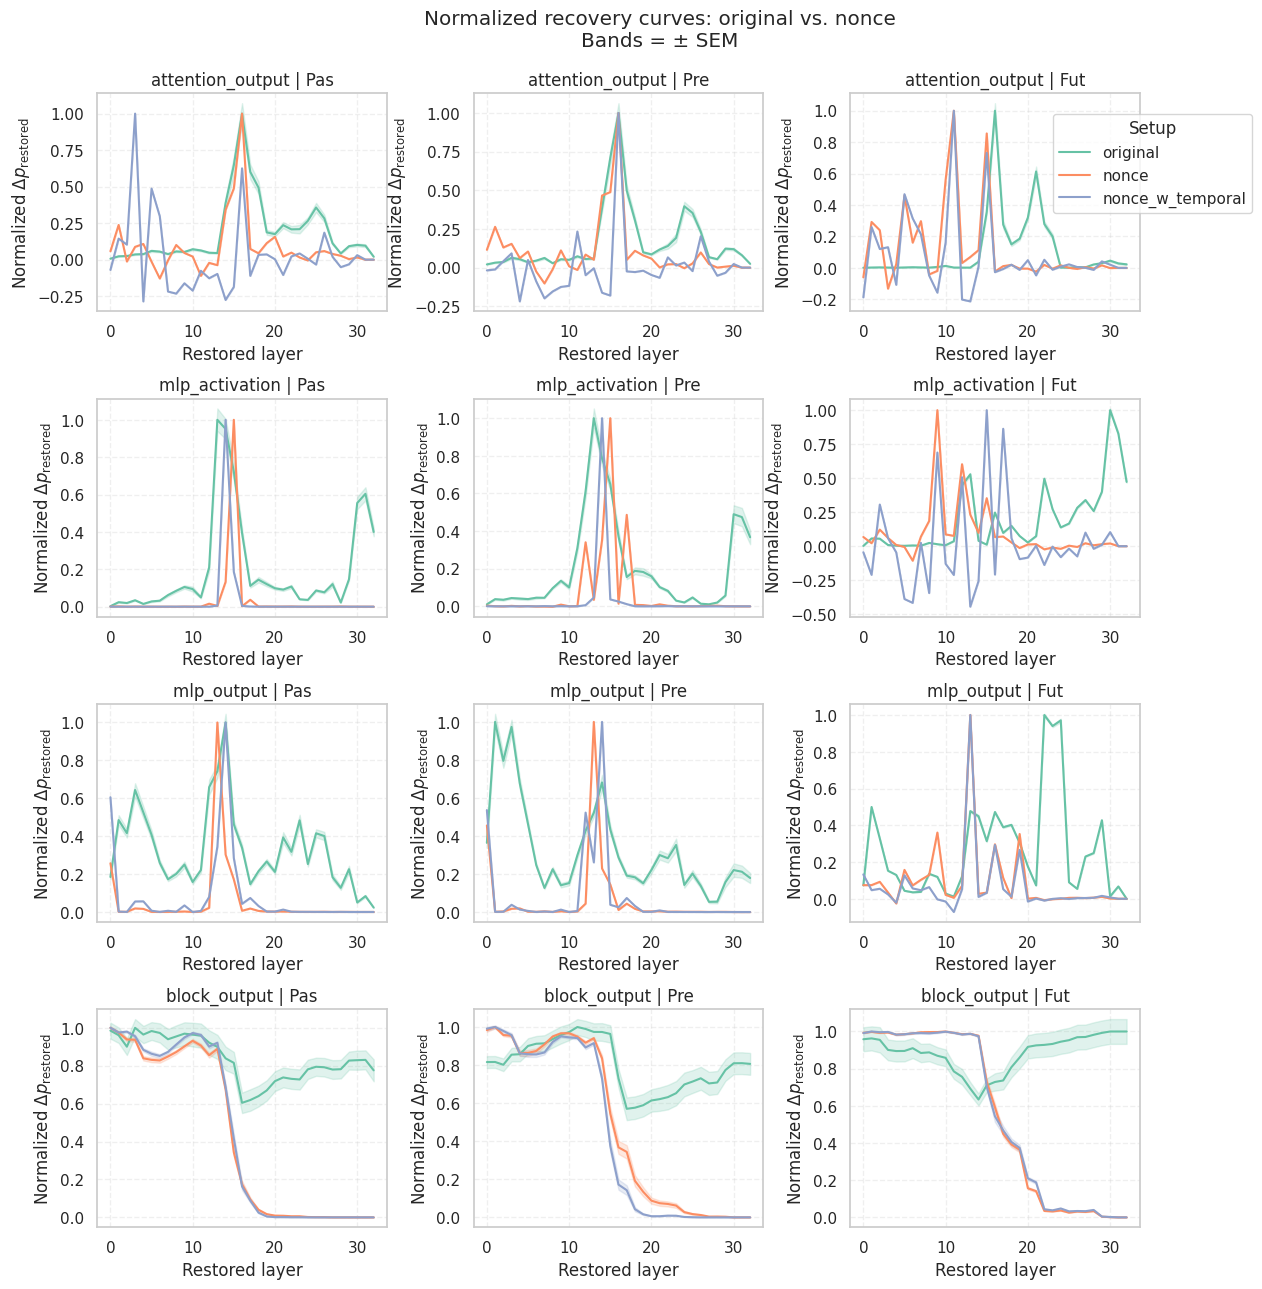

In [18]:
setup_order = ["original", "nonce", "nonce_w_temporal"]
# setup_order = ["nonce", "nonce_w_temporal"]

palette   = dict(zip(setup_order, sns.color_palette("Set2", n_colors=len(setup_order))))

streams = ["attention_output", "mlp_activation", "mlp_output", "block_output"]        # e.g. ["attention_output", "mlp_activation", ...]
tenses  = ["pas", "pre", "fut"]
# ylim = [0.6, 0.5, 0.5, 1.0]

n_rows = len(streams)
n_cols = len(tenses)
fig, axes = plt.subplots(
    n_rows,
    n_cols,
    figsize=(5 * n_cols, 3.5 * n_rows),
    sharey=False
)

# If there's only one row or column, make axes 2D for consistency
if n_rows == 1:
    axes = np.expand_dims(axes, axis=0)
if n_cols == 1:
    axes = np.expand_dims(axes, axis=1)

# ─── DRAW LINES AND BANDS INLINE ───────────────────────────────────────────────
for i, stream in enumerate(streams):
    for j, tense in enumerate(tenses):
        ax = axes[i][j]
        sub = agg[(agg["stream"] == stream) & (agg["tense"] == tense)]
        
        # Fplot mean ± SEM vs. restore_layer
        for lang in setup_order:
            sl = sub[sub["setup"] == lang].sort_values("restore_layer")
            if sl.empty:
                continue
            x = sl["restore_layer"]
            y = sl["norm_delta"]
            se = sl["sem"]
            
            ax.plot(
                x, y,
                label=lang,
                color=palette[lang]
            )
            ax.fill_between(
                x,
                y - se,
                y + se,
                alpha=0.2,
                color=palette[lang]
            )
            
#         ax.set_ylim(0.0, ylim[i])
        ax.set_title(f"{stream} | {tense.capitalize()}")
        ax.set_xlabel("Restored layer")
        ax.set_ylabel(r"Normalized $\Delta p_{\mathrm{restored}}$")
        ax.grid(True, linestyle='--', alpha=0.3)

# ─── ADD LEGEND ───────────────────────────────────────────────────────────────
# Place a single legend outside on the right
handles, labels = axes[0][1].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    title="Setup",
    bbox_to_anchor=(0.9, 0.87),
    loc="center right"
)

plt.subplots_adjust(
    top=0.92,
    right=0.82,
    hspace=0.4,
    wspace=0.3
)
fig.suptitle("Normalized recovery curves: original vs. nonce\nBands = ± SEM", y=0.98)
plt.show()

In [19]:
def sig_stars(p):
    if p < 1e-3:
        return '***'
    elif p < 1e-2:
        return '**'
    elif p < 5e-2:
        return '*'
    else:
        return ''

print("Spearman rank correlations (original vs. nonce):")
for (stream, tense), group in agg.groupby(['stream','tense']):
    orig = group[group.setup=='original'].sort_values('restore_layer')['norm_delta'].values
    nonc = group[group.setup=='nonce'].sort_values('restore_layer')['norm_delta'].values
    rho, pval = spearmanr(orig, nonc)
    stars = sig_stars(pval)
    print(f"  {stream:16s} | {tense:3s} : ρ = {rho:.3f}, p = {pval:.3g} {stars}")

Spearman rank correlations (original vs. nonce):
  attention_output | fut : ρ = -0.152, p = 0.4 
  attention_output | pas : ρ = 0.341, p = 0.0524 
  attention_output | pre : ρ = 0.150, p = 0.403 
  block_output     | fut : ρ = -0.556, p = 0.00078 ***
  block_output     | pas : ρ = 0.654, p = 3.62e-05 ***
  block_output     | pre : ρ = 0.575, p = 0.000466 ***
  mlp_activation   | fut : ρ = -0.223, p = 0.212 
  mlp_activation   | pas : ρ = 0.402, p = 0.0204 *
  mlp_activation   | pre : ρ = 0.394, p = 0.0233 *
  mlp_output       | fut : ρ = 0.025, p = 0.888 
  mlp_output       | pas : ρ = 0.579, p = 0.000412 ***
  mlp_output       | pre : ρ = 0.527, p = 0.00164 **
